# Utils
Utility functions for PyrNet

In [1]:
#|hide
#|default_exp utils

In [2]:
#|export
from numpy.typing import ArrayLike, NDArray
import numpy as np
from scipy.signal.windows import gaussian
import jstyleson as json
from addict import Dict as adict
from operator import itemgetter
from toolz import keyfilter
import pyproj

# python -m pip install git+https://github.com/hdeneke/trosat-base.git#egg=trosat-base
import trosat.sunpos as sp

In [ ]:
# extra imports for demonstration
import sys,os
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
#import pkg_resources as pkg_res
import importlib.resources

import pyrnet

## Representation of Time
Unifying various representations of time to numpy.datetime64 comes in handy when handling user inputs.

In [4]:
#|export
EPOCH_JD_2000_0 = np.datetime64("2000-01-01T12:00")
def to_datetime64(time, epoch=EPOCH_JD_2000_0):
    """
    Convert various representations of time to datetime64.

    Parameters
    ----------
    time : list, ndarray, or scalar of type float, datetime or datetime64
        A representation of time. If float, interpreted as Julian date.
    epoch : np.datetime64, default JD2000.0
        The epoch to use for the calculation

    Returns
    -------
    datetime64 or ndarray of datetime64
    """
    jd = sp.to_julday(time, epoch=epoch)
    jdms = np.int64(86_400_000*jd)
    return epoch + jdms.astype('timedelta64[ms]')

In [5]:
# testing to_datetime64
date_jd = 5203.5 # 2014-04-01T00:00
date_dt = dt.datetime(2014,4,1,12,10)
date_pd = pd.date_range("2014-04-01","2014-04-03",freq='1d')
date_list = [dt.date(2014,4,1), dt.date(2014,4,2)]
assert np.datetime64("2014-04-01T00:00")==to_datetime64(date_jd)
assert np.datetime64("2014-04-01T12:10")==to_datetime64(date_dt)
assert np.array_equal(
    np.array([np.datetime64("2014-04-01"),
                 np.datetime64("2014-04-02"),
                 np.datetime64("2014-04-03")]
                ).astype("datetime64[ms]"),
    to_datetime64(date_pd))
assert np.array_equal(
    np.array([np.datetime64("2014-04-01"),
                 np.datetime64("2014-04-02")]
                ).astype("datetime64[ms]"),
    to_datetime64(date_list))

## Json netcdf config tools
The netCDF attributes and encoding variables are stored in [CF-Compliance](https://cfconventions.org/) json files. The following utility functions are used to parse the json and return attribute and encoding dictionary's to be used with xarray.

In [6]:
#|export
def read_json(fpath: str, *, object_hook: type = adict, cls = None) -> dict:
    """ Parse json file to python dict.
    """
    with open(fpath,"r") as f:
        js = json.load(f, object_hook=object_hook, cls=cls)
        return js

def pick(whitelist: list[str], d: dict) -> dict:
    """ Keep only whitelisted keys from input dict.
    """
    return keyfilter(lambda k: k in whitelist, d)

def omit(blacklist: list[str], d: dict) -> dict:
    """ Omit blacklisted keys from input dict.
    """
    return keyfilter(lambda k: k not in blacklist, d)

def get_var_attrs(d: dict) -> dict:
    """
    Parse cf-compliance dictionary.

    Parameters
    ----------
    d: dict
        Dict parsed from cf-meta json.

    Returns
    -------
    dict
        Dict with netcdf attributes for each variable.
    """
    get_vars = itemgetter("variables")
    get_attrs = itemgetter("attributes")
    vattrs = {k: get_attrs(v) for k,v in get_vars(d).items()}
    for k,v in get_vars(d).items():
        vattrs[k].update({
            "dtype": v["type"],
            "gzip":True,
            "complevel":6
        })
    return vattrs

def get_attrs_enc(d : dict) -> (dict,dict):
    """ Split variable attributes in attributes and encoding-attributes.
    """
    _enc_attrs = {
        "scale_factor",
        "add_offset",
        "_FillValue",
        "dtype",
        "zlib",
        "gzip",
        "complevel",
        "calendar",
    }
    # extract variable attributes
    vattrs = {k: omit(_enc_attrs, v) for k, v in d.items()}
    # extract variable encoding
    vencode = {k: pick(_enc_attrs, v) for k, v in d.items()}
    return vattrs, vencode

### Usage:

In [ ]:
#|dropout
fn = os.path.join(importlib.resources.files("pyrnet"), "share/pyrnet_cfmeta.json")

config =  dict(
    contributor_name = "Jon Doe; Roger Rogers",
    contributor_role = "Set-up; Tear-down",
    project = "Notebook Example",
    creator_name = "Adam Alpha",
    dt = np.datetime64("now").item(),
    sdate = dt.datetime(2014,4,1,12,0),
    edate = dt.datetime(2014,4,2,18,0),
    notes = "This is just an example.",
)

# parse the json file
cfdict = read_json(fn)

# get global attributes:
gattrs = cfdict['attributes']

# apply config
gattrs = {k:v.format_map(config) for k,v in gattrs.items()}

gattrs

{'Title': 'TROPOS pyranometer network (PyrNet) observations',
 'Institution': 'Leibniz Institute for Tropospheric Research (TROPOS)',
 'Department': 'Remote Sensing of Atmospheric Processes',
 'Department_team': 'Clouds, Aerosol and Radiation',
 'Address': 'Permoser Str. 15, 04318 Leipzig, Germany',
 'Source': 'TROPOS pyranometer network (PyrNet)',
 'Contact_person': 'Andreas Macke and the clouds, aerosol and radiation team of the remote sensing department, mailto:andreas.macke@tropos.de',
 'Contributor_name': 'Jon Doe; Roger Rogers',
 'Contributor_role': 'Set-up; Tear-down',
 'Authors_software': 'Hartwig Deneke, Jonas Witthuhn, mailto:deneke@tropos.de',
 'Creator_name': 'Adam Alpha',
 'Project': 'Notebook Example',
 'References': 'https://doi.org/10.5194/amt-9-1153-2016',
 'Standard_name_vocabulary': 'CF Standard Name Table v81',
 'Conventions': 'CF-1.10, ACDD-1.3',
 'License': 'CC-BY-SA 3.0'}

In [8]:
#|dropout
# get variable attributes
d = get_var_attrs(cfdict)

# split encoding attributes
vattrs, vencode = get_attrs_enc(d)

vattrs, vencode

({'ta': {'units': 'K',
   'long_name': 'air temperature',
   'standard_name': 'air_temperature',
   'valid_range': [0, 10000]},
  'rh': {'units': '1',
   'long_name': 'air relative humidity',
   'standard_name': 'relative_humidity',
   'valid_range': [0, 10000]},
  'battery_voltage': {'units': 'V',
   'standard_name': 'battery_voltage',
   'valid_range': [0, 6400]},
  'ghi': {'units': 'W m-2',
   'long_name': 'downwelling shortwave flux',
   'standard_name': 'downwelling_shortwave_flux_in_air',
   'valid_range': [0, 60000]},
  'gti': {'units': 'V',
   'long_name': 'downwelling shortwave flux measured on secondary platform, might be tilted',
   'standard_name': 'downwelling_shortwave_flux_in_air',
   'valid_range': [0, 60000]},
  'station': {'units': '-', 'long_name': 'PyrNet unit box number'},
  'szen': {'standard_name': 'solar_zenith_angle',
   'units': 'degree',
   'valid_range': [0, 36000]},
  'sazi': {'standard_name': 'solar_azimuth_angle',
   'units': 'degree',
   'valid_range': [

## Euclidian distances of stations

In [9]:
#|export
def get_xy_coords(lon, lat, lonc=None, latc=None):
    """
    Calculate Cartesian coordinates of network stations, relative to the mean
    lon/lat of the stations
    """
    GEOD = pyproj.Geod(ellps='WGS84')

    n  = len(lon)
    if lonc is None:
        lonc = lon.mean()
    if latc is None:
        latc = lat.mean()

    az, _, d = np.array([GEOD.inv(lonc, latc, lon[i], lat[i]) for i in range(n)]).T
    x = d*np.sin(np.deg2rad(az))
    y = d*np.cos(np.deg2rad(az))
    return x,y

In [10]:
#|export
def pairwise_distance_matrix( x: ArrayLike, y: ArrayLike ) -> NDArray:
    """
    Get square matrix with Euclidian distances of stations

    Parameters
    ----------
    x: array_like
        X coordinates
    y: array_like
        Y coordinates

    Returns
    -------
    ndarray
        A square matrix with Euclidian distances of stations
    """
    x = np.array(x)
    y = np.array(y)
    return np.sqrt( (x[None,:]-x[:,None])**2+(y[None,:]-y[:,None])**2 )

In [11]:
x = [0, 1, 2]
y = [0, 0, 0]
dist = pairwise_distance_matrix(x,y)
print(dist)
assert dist[0,0]==dist[1,1]==dist[2,2]==0
assert dist[0,1]==dist[1,0]==1
assert dist[0,2]==dist[2,0]==2

[[0. 1. 2.]
 [1. 0. 1.]
 [2. 1. 0.]]


## Fourier utility

### Create a gaussian window
Convert a scale parameter *J* to FWHM of a normal distribution

$\mathrm{FWHM} = 2 \sqrt{2 \ln 2} \sigma = f \sigma$

define FWHM with scale parameter *J*, so that :
$\mathrm{FWHM} = 60*2^J$



In [12]:
for J in range(-2,4):
    print(f"J = {J:2d} -> FWHM(J) = {60.*2**J}")

J = -2 -> FWHM(J) = 15.0
J = -1 -> FWHM(J) = 30.0
J =  0 -> FWHM(J) = 60.0
J =  1 -> FWHM(J) = 120.0
J =  2 -> FWHM(J) = 240.0
J =  3 -> FWHM(J) = 480.0


sum of distribution density: 1.000


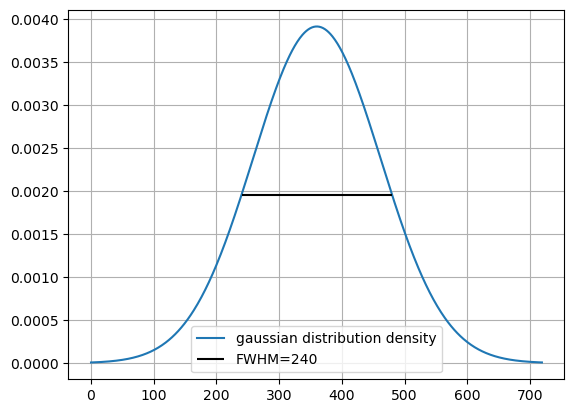

In [13]:
J=2
f = 2.0*np.sqrt(2*np.log(2))
sig = (60.0/f)*2**J

# FWHM from scale parameter
FWHM = 60*2**J

# normalized gaussian distribution
g  = gaussian(3*FWHM, sig, sym=False)
# distribution density (sums up to 1)
gd = g/(np.sqrt(2*np.pi)*sig)
print(f"sum of distribution density: {np.sum(gd):.3f}")

x0 = np.argmax(gd)
x1, x2 = x0-.5*FWHM, x0+.5*FWHM
plt.figure()
_ = plt.plot(g/np.sqrt(2*np.pi)/sig, label='gaussian distribution density')
_ = plt.hlines(.5*np.max(gd),x1,x2,color='k', label=f'FWHM={FWHM}')
_ = plt.grid()
_ = plt.legend()
plt.show()

/home/jonas/miniconda3/envs/pyrnet/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


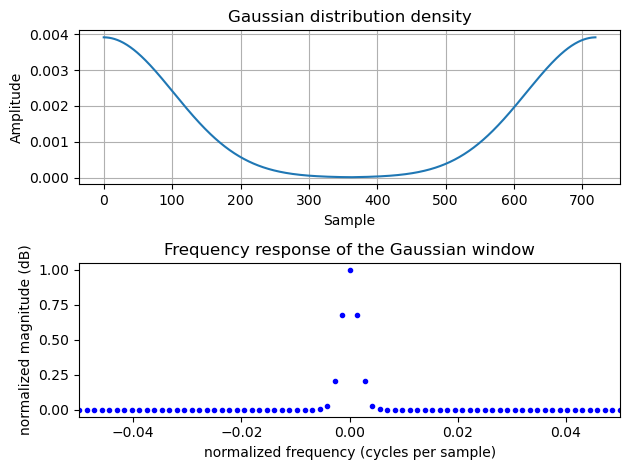

In [14]:
# shift array, so that it starts with the maxima
gd_rolled = np.roll(gd, np.floor_divide(3*FWHM, 2))

# calculate the frequency response of the Gaussian window
gd_fft = np.fft.fft(gd_rolled)
fft_freq = np.fft.fftfreq(gd_rolled.shape[0])

fig, axs = plt.subplots(2,1)
_ = axs[0].set_title("Gaussian distribution density")
_ = axs[0].plot(gd_rolled)
_ = axs[0].grid(True)
_ = axs[0].set_xlabel('Sample')
_ = axs[0].set_ylabel('Amplitude')

_ = axs[1].set_title("Frequency response of the Gaussian window")
_ = axs[1].plot(fft_freq,gd_fft,'b.')
_ = axs[1].set_xlabel('normalized frequency (cycles per sample)')
_ = axs[1].set_ylabel('normalized magnitude (dB)')
_ = axs[1].set_xlim([-.05,.05])
fig.tight_layout()

In [15]:
#|export
def gauss_fwin_fwhm(fwhm: float, N: int = 86400) -> NDArray:
    """
    Convert scale parameter to FWHM of Normal distribution see
    [https://en.wikipedia.org/wiki/Full_width_at_half_maximum#Normal_distribution]

    Parameters
    ----------
    fwhm: float
        FWHM of the gaussian distribution
    N: int
        Number of points in the output window. If zero, an empty array is returned. An exception is thrown when it is negative.
        The default is 86400 (seconds per day).

    Returns
    -------
    ndarray
        Frequency response of the gaussian window
    """
    f = 2.0*np.sqrt(2*np.log(2))
    sig = fwhm/f
    g  = gaussian(N, sig, sym=False)/np.sqrt(2*np.pi)/sig
    return np.fft.fft(np.roll(g, np.floor_divide(N, 2)))

def gauss_fwin(J: float, N: int=86400) -> NDArray:
    """
    Convert scale parameter to FWHM of Normal distribution see
    [https://en.wikipedia.org/wiki/Full_width_at_half_maximum#Normal_distribution]

    Parameters
    ----------
    J: float
        scale parameter for FWHM, with FWHM=60*2**J
    N: int
        Number of points in the output window. If zero, an empty array is returned. An exception is thrown when it is negative.
        The default is 86400 (seconds per day).

    Returns
    -------
    ndarray
        Frequency response of the gaussian window
    """
    fwhm = 60.*2**J
    return gauss_fwin_fwhm(fwhm, N=N)



### Smoothing Data by convolution

In [16]:
#|export
def smooth_fwhm(y: ArrayLike, fwhm: float, axis: int = 0) -> NDArray:
    """
    Smooth data with gaussian window by convolution

    Parameters
    ----------
    y: array_like
        Input array.
    fwhm: float
        FWHM of the gaussian window to be convolved with the input array.
    axis: int, optional
        Axis over which to smoothing is applied.

    Returns
    -------
    ndarray
        Smoothed array of the same shape as the input array `y`.
    """
    Y = np.fft.fft(y, axis=axis)
    W = gauss_fwin_fwhm(fwhm, y.shape[axis])
    if y.ndim > 1:
        W = np.expand_dims(W, axis=axis).T
    return np.fft.ifft(Y * W, axis=axis).real

def smooth(y: ArrayLike, J: float, axis: int = 0) -> NDArray:
    """
    Smooth data with gaussian window by convolution

    Parameters
    ----------
    y: array_like
        Input array.
    J: float
        Scale parameter for the FWHM (FWHM=60*2**J) of the
        gaussian window to be convolved with the input array.
    axis: int, optional
        Axis over which to smoothing is applied.

    Returns
    -------
    ndarray
        Smoothed array of the same shape as the input array `y`.
    """
    fwhm = 60.*2**J
    return smooth_fwhm(y, fwhm, axis=axis)


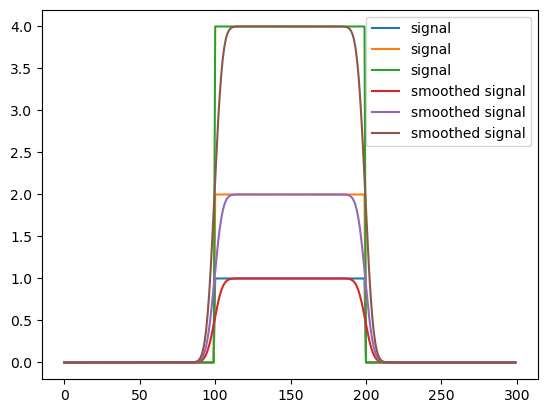

In [17]:
axis=0
sig = np.repeat([0., 1., 0.], 100)
sig2 = np.vstack((sig*2,sig*4))

fwhm = 10
filtered = smooth_fwhm(sig, fwhm, axis=0)
filtered2 = smooth_fwhm(sig2, fwhm, axis=1)


fig, ax = plt.subplots(1,1)
_ = ax.plot(sig, label='signal')
_ = ax.plot(sig2.T, label='signal')
_ = ax.plot(filtered, label='smoothed signal')
_ = ax.plot(filtered2.T, label='smoothed signal')
_ = ax.legend()
fig.show()

In [18]:
# from pyrnet import pyrnet
# date = dt.datetime(2013,7,15)
# pyr  = pyrnet.read_pyrnet(date, 'hope_juelich')
# 
# z0 = pyr.ghi.data[:,0]
# z1 = smooth(pyr.ghi.data, 0, axis=0)
# z2 = smooth(pyr.ghi.data.T, 5, axis=-1)
# 
# fig, ax = plt.subplots(1,1)
# _ = ax.plot(z0,'k')
# _ = ax.plot(z1[:,0],'g')
# _ = ax.plot(z2[0,:],'r')
# _ = ax.grid(True)
# fig.show()

# Tilted Pyranometer Utils
Functions to calculate apparent zenith angle and simple correction to horizontal irradiance.

In [19]:
#|export
#|dropcode
def make_iter(x):
    """Check if x is an iterable, if not make it so and return np.array(x).
    """
    if isinstance(x, str):
        x = [x]
    try:
        iter(x)
    except:
        x = [x]
    return np.array(x)

def check_tilted(x):
    """
    Check x attrs 'hangle' and 'vangle' if available and >0.1 degree.
    
    Parameters
    ----------
    x: xr.DataArray

    Returns
    -------
    list of bools
        True if vangle attribute > 0.1 degree. Same length as 'x.vangle'.
    """
    is_tilted = np.full(x.shape[1], False)
    # check if this is a tilted irradiance measurement
    if "vangle" in x.attrs:
        vangle = make_iter(x.attrs["vangle"])
        hangle = make_iter(x.attrs["hangle"])
        try:
            assert len(vangle)==len(is_tilted)
        except:
            raise Exception(f"Attribute vangle and hangle of {var} should have the same length as the station dimension.")
        is_tilted = np.abs(vangle)>0.1
    return is_tilted

In [20]:
#|export
def calc_apparent_coszen(pitch,yaw,zen,azi):
    """
    Calculate cosine of apparent zenith angle

    Parameters:
    -----------
    pitch: float, array of float
        Platform pitch angle (degrees) - Angle between vertical and platfrom normal vector, e.g. platform zenith angle
    yaw: float, array of float
        Platform yaw angle (degrees) - Angle positive clockwise from north, e.g. platfrom azimuth angle
    zen: flaot, array of float
        Solar zenith angle (degrees)
    azi: float, array of float
        Solar azimuth angle (degrees)

    Returns:
    --------
    coszen: float, array of float
        The cosine of the platform apparent zenith angle (angle between solar and platform normal vector)
    """
    #calculate the angle between radiometer normal to sun position vector
    p = np.deg2rad(-1.*pitch)
    z = np.deg2rad(zen)
    g = np.deg2rad(azi - yaw) 
    coszen = -np.sin(z)*np.sin(p)*np.cos(g) + np.cos(z)*np.cos(p)
    return coszen # cos of angle between radiometer normal and solar vector

def tilt_correction_factor(dp, dy, szen, sazi):
    tczen = calc_apparent_coszen(dp, dy, szen, sazi)
    return np.cos(np.deg2rad(szen))/tczen

def bias_optimize_pitch(vals,ghi,ghi_t,zen,azi,dp):
    dy = vals
    F = ghi_t*tilt_correction_factor(dp,dy,zen,azi)
    return np.nanmean(np.abs(ghi-F))

def bias_optimize_yaw(vals,ghi,ghi_t,zen,azi,dy):
    dp = vals
    F = ghi_t*tilt_correction_factor(dp,dy,zen,azi)
    return np.nanmean(np.abs(ghi-F))

def bias_optimize(vals,ghi,ghi_t,zen,azi):
    dp, dy = vals
    F = ghi_t*tilt_correction_factor(dp, dy, zen, azi)
    return np.nanmean(np.abs(ghi-F))

In [21]:
assert 10==np.round(np.rad2deg(np.arccos(calc_apparent_coszen(20,180,30,180))),3)
assert 60==np.round(np.rad2deg(np.arccos(calc_apparent_coszen(30,0,30,180))),3)
assert tilt_correction_factor(30,180,20,180)<1  # zenith distance from tilted to sun is shorter than horizontal to sun
assert tilt_correction_factor(40,180,20,180)==1 # zenith distance from tilted to sun is equal horizontal to sun
assert tilt_correction_factor(41,180,20,180)>1  # zenith distance from tilted to sun is longer than horizontal to sun

In [22]:
#|hide
# Export module
# Requires *nbdev* to export and update the *../lib/utils.py* module
import nbdev.export
import nbformat as nbf
name = "utils"

# Export python module
nbdev.export.nb_export( f"{name}.ipynb" ,f"../../src/pyrnet")

# Export to docs
ntbk = nbf.read(f"{name}.ipynb", nbf.NO_CONVERT)

text_search_dict = {
    "#|hide": "remove-cell",  # Remove the whole cell
    "#|dropcode": "hide-input",  # Hide the input w/ a button to show
    "#|dropout": "hide-output"  # Hide the output w/ a button to show
}
for cell in ntbk.cells:
    cell_tags = cell.get('metadata', {}).get('tags', [])
    for key, val in text_search_dict.items():
            if key in cell['source']:
                if val not in cell_tags:
                    cell_tags.append(val)
    if len(cell_tags) > 0:
        cell['metadata']['tags'] = cell_tags
    nbf.write(ntbk, f"../../docs/source/nbs/{name}.ipynb")